<a href="https://colab.research.google.com/github/mfakgun97/Driver-Drowsiness-Image-Data-CNN/blob/main/Assingment_DriverDistraction_Starting_code_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install packages if needed with this command:

import os
import kaggle
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
### NEW
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

# From here, add any libraries that you might need for the rest of your code

# 1. Load dataset


In [ ]:
# download data
data_dir = 'driver-inattention-detection-dataset'
if not os.path.isdir(data_dir):
    kaggle.api.dataset_download_files('zeyad1mashhour/driver-inattention-detection-dataset',
                                    path=data_dir, unzip=True)

Dataset URL: https://www.kaggle.com/datasets/zeyad1mashhour/driver-inattention-detection-dataset


In [ ]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# read the file containing the class labels
with open(os.path.join(data_dir, 'train', '_classes.txt')) as f:
    classes = list(map(str.strip, f))

# read image paths and labels and store them in pandas dataframes
with open(os.path.join(data_dir, 'test', '_annotations.txt'), 'r') as f:
    df_test = pd.DataFrame(dict(img=os.path.join(data_dir, 'test', line.split()[0]),
                                label=classes[int(line.strip()[-1])]) for line in f)

with open(os.path.join(data_dir, 'valid', '_annotations.txt'), 'r') as f:
    df_val = pd.DataFrame(dict(img=os.path.join(data_dir, 'valid', line.split()[0]),
                               label=classes[int(line.strip()[-1])]) for line in f)

with open(os.path.join(data_dir, 'train', '_annotations.txt'), 'r') as f:
    df_train = pd.DataFrame(dict(img=os.path.join(data_dir, 'train', line.split()[0]),
                                 label=classes[int(line.strip()[-1])]) for line in f if len(line.split())>1)

# pre-processing parameters
image_unit_res = 8
img_height, img_width = 9*image_unit_res, 16*image_unit_res # 16:9 preserve aspect ratio
batch_size = 32

def add_noise(img):
    std_coeff = 50*np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

data_gen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise)

train_data = data_gen.flow_from_dataframe(
    df_train, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale')

val_data = data_gen.flow_from_dataframe(
    df_val, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale')

test_data = data_gen.flow_from_dataframe(
    df_test, x_col='img', y_col='label',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale')


Found 11948 validated image filenames belonging to 6 classes.
Found 1922 validated image filenames belonging to 6 classes.
Found 985 validated image filenames belonging to 6 classes.


In [ ]:
print(classes)

['DangerousDriving', 'Distracted', 'Drinking', 'SafeDriving', 'SleepyDriving', 'Yawn']


In [ ]:
print(df_test)

                                                   img             label
0    driver-inattention-detection-dataset/test/gB_7...     SleepyDriving
1    driver-inattention-detection-dataset/test/gB_7...              Yawn
2    driver-inattention-detection-dataset/test/gB_8...       SafeDriving
3    driver-inattention-detection-dataset/test/gB_1...  DangerousDriving
4    driver-inattention-detection-dataset/test/gB_9...  DangerousDriving
..                                                 ...               ...
980  driver-inattention-detection-dataset/test/gA_5...       SafeDriving
981  driver-inattention-detection-dataset/test/gB_8...       SafeDriving
982  driver-inattention-detection-dataset/test/gA_1...       SafeDriving
983  driver-inattention-detection-dataset/test/gB_8...       SafeDriving
984  driver-inattention-detection-dataset/test/gA_3...       SafeDriving

[985 rows x 2 columns]


# 2. Visualise data and plot data distribution

In [ ]:
# Assume classes list is already defined, e.g., classes = ['cat', 'dog', 'bird', ...]
# Create a mapping dictionary: label -> integer index
label_to_int = {label: idx for idx, label in enumerate(classes)}

# Convert labels in each DataFrame to integer values
df_train['label_int'] = df_train['label'].map(label_to_int)
df_val['label_int']   = df_val['label'].map(label_to_int)
df_test['label_int']  = df_test['label'].map(label_to_int)

# Now convert the integer labels into one-hot encoded arrays.
y_train_one_hot = to_categorical(df_train['label_int'])
y_val_one_hot   = to_categorical(df_val['label_int'])
y_test_one_hot  = to_categorical(df_test['label_int'])

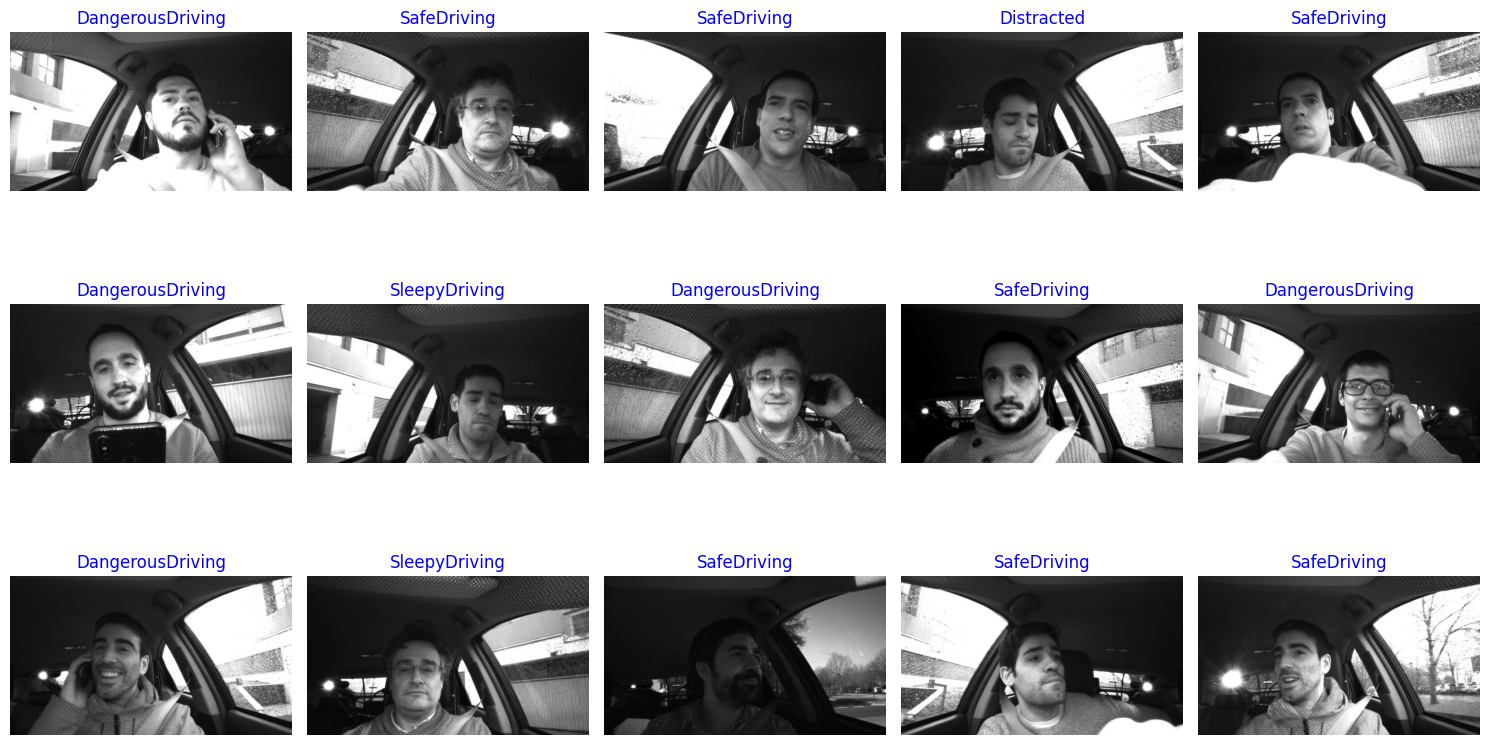

In [ ]:
sample_indices = np.random.choice(df_train.index, 15, replace=False)

# Set up the figure with a grid (e.g., 3 rows x 5 columns)
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))
axes = axes.flatten()  # Flatten the array for easier iteration

for ax, idx in zip(axes, sample_indices):
    img_path = df_train.loc[idx, 'img']   # get the full path to the image
    label    = df_train.loc[idx, 'label']  # get the label as text

    # Load the image. Since the images are in grayscale, we specify the colormap.
    image = mpimg.imread(img_path)

    ax.imshow(image, cmap='gray')
    ax.set_title(label, fontsize=12, color='blue')  # Display label as the title
    ax.axis('off')  # Remove axes for clarity

plt.tight_layout()
plt.show()

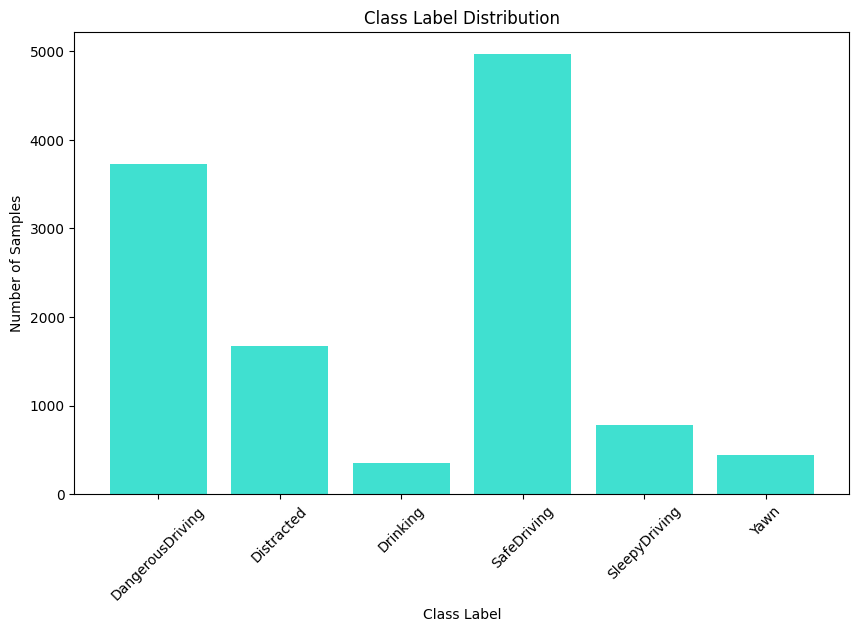

In [ ]:
label_counts = df_train['label'].value_counts().sort_index()  # sort_index to keep the order consistent with classes

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(label_counts.index, label_counts.values, color='turquoise')

plt.xlabel('Class Label')
plt.ylabel('Number of Samples')
plt.title('Class Label Distribution')
plt.xticks(rotation=45)  # Rotate labels if they are long or many

plt.show()

# 3. Train and Evaluation functions

In [ ]:
# Define the input image dimensions.
# Here, img_height = 72, img_width = 128, and channels = 1 (grayscale)
input_shape = (72, 128, 1)

# Build the model
model = Sequential([
    # --- Block 1 ---
    Conv2D(filters=8, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2)),

    # --- Block 2 ---
    Conv2D(filters=8, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # --- Block 3 ---
    Conv2D(filters=8, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    # Flatten the output to create a 784-dimensional vector (if the math works out as above)
    Flatten(),

    # Dense layer projecting the 784-dimensional vector to 10 dimensions, followed by ReLU
    Dense(10, activation='relu'),

    # Final dense layer projecting the 10-dimensional vector to 6 logits (one for each class)
    # For classification, you can choose to either use a linear activation (if you plan to use logits)
    # or 'softmax' if you want probabilities.
    Dense(6, activation='softmax')  # or activation=None if you wish to output raw logits
])

# Print the model summary to verify the architecture
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 70, 126, 8)          │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 35, 63, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 33, 61, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 30, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 28, 8)           │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 7, 14, 8)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │           7,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,164 (35.80 KB)

 Trainable params: 9,164 (35.80 KB)

 Non-trainable params: 0 (0.00 B)

# 4. Model training

In [ ]:
model.compile(
    optimizer='adam',                    # You can choose other optimizers if needed
    loss='categorical_crossentropy',     # Use categorical_crossentropy for one-hot encoded labels
    metrics=['accuracy']                 # List the metrics you want to monitor
)


In [ ]:
history = model.fit(
    train_data,  # your training data generator or dataset
    epochs=10,   # or your chosen number of epochs
    validation_data=val_data  # use the provided validation set
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 80s 208ms/step - accuracy: 0.3829 - loss: 1.6224 - val_accuracy: 0.5593 - val_loss: 1.2562
Epoch 2/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 75s 201ms/step - accuracy: 0.5501 - loss: 1.1867 - val_accuracy: 0.6374 - val_loss: 1.0285
Epoch 3/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 73s 194ms/step - accuracy: 0.6181 - loss: 0.9995 - val_accuracy: 0.6769 - val_loss: 0.9093
Epoch 4/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 73s 196ms/step - accuracy: 0.6642 - loss: 0.9072 - val_accuracy: 0.6639 - val_loss: 0.8940
Epoch 5/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 82s 197ms/step - accuracy: 0.6764 - loss: 0.8561 - val_accuracy: 0.7128 - val_loss: 0.8243
Epoch 6/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 74s 197ms/step - accuracy: 0.6934 - loss: 0.8139 - val_accuracy: 0.7138 - val_loss: 0.8246
Epoch 7/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 74s 196ms/step - accuracy: 0.7130 - loss: 0.7695 - val_accuracy: 0.7216 - val_loss: 0.7939
Epoch 8/10
374/374 ━━━━━━━━━━━━━━━━━━━━ 72s 193ms/step - accuracy: 0.7156 - loss: 0

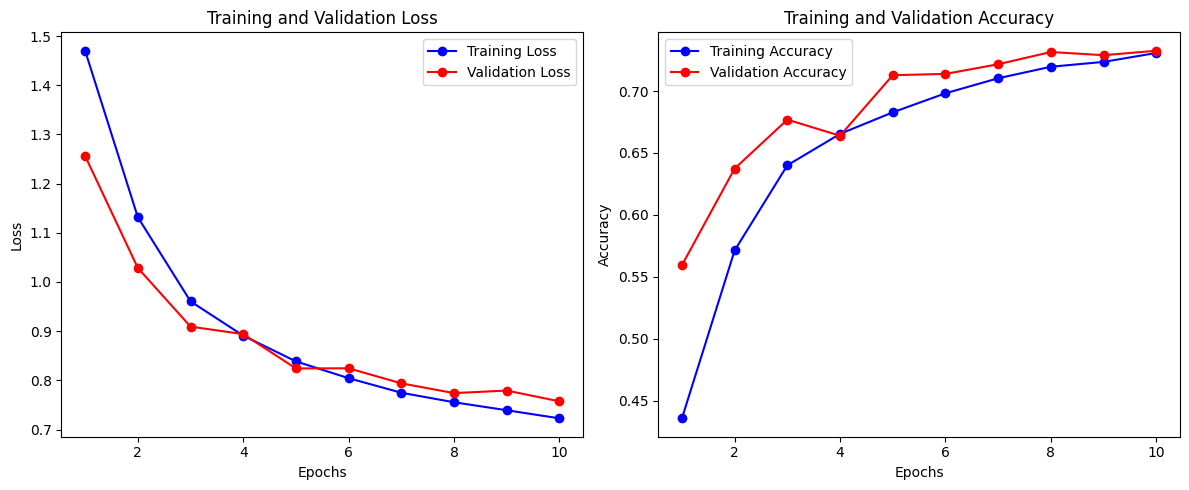

In [ ]:


# Extract metrics from the training history.
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy', history.history.get('acc'))  # 'accuracy' or 'acc'
val_accuracy = history.history.get('val_accuracy', history.history.get('val_acc'))

epochs = range(1, len(loss) + 1)

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Get true labels and model probabilities for the validation set
y_val_true = val_data.classes  # true labels as integers (length = number of validation samples)
y_val_prob = model.predict(val_data)  # predicted probabilities for each class; shape: (num_samples, 6)

# Binarize the true labels for ROC computation.
n_classes = 6
y_val_true_bin = label_binarize(y_val_true, classes=range(n_classes))

61/61 ━━━━━━━━━━━━━━━━━━━━ 8s 121ms/step


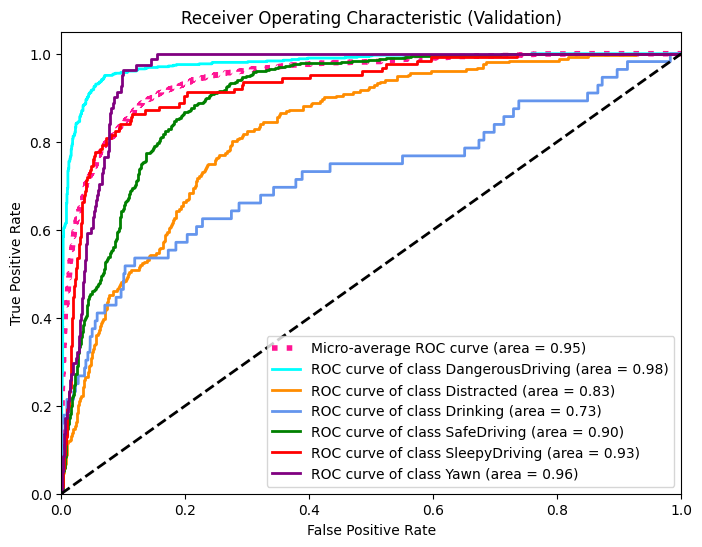

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val_true_bin[:, i], y_val_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_val_true_bin.ravel(), y_val_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:0.2f})',
         color='deeppink', linestyle=':', linewidth=4)

colors = ['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Validation)')
plt.legend(loc="lower right")
plt.show()


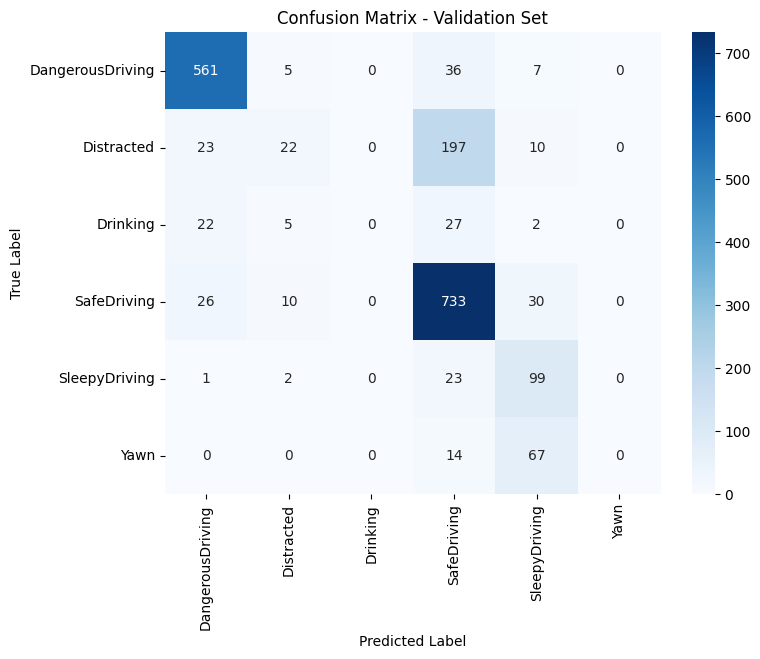

In [ ]:


# Predicted labels for validation set
y_val_pred = np.argmax(y_val_prob, axis=1)

# Compute confusion matrix
cm_val = confusion_matrix(y_val_true, y_val_pred)

# Plot confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - Validation Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step


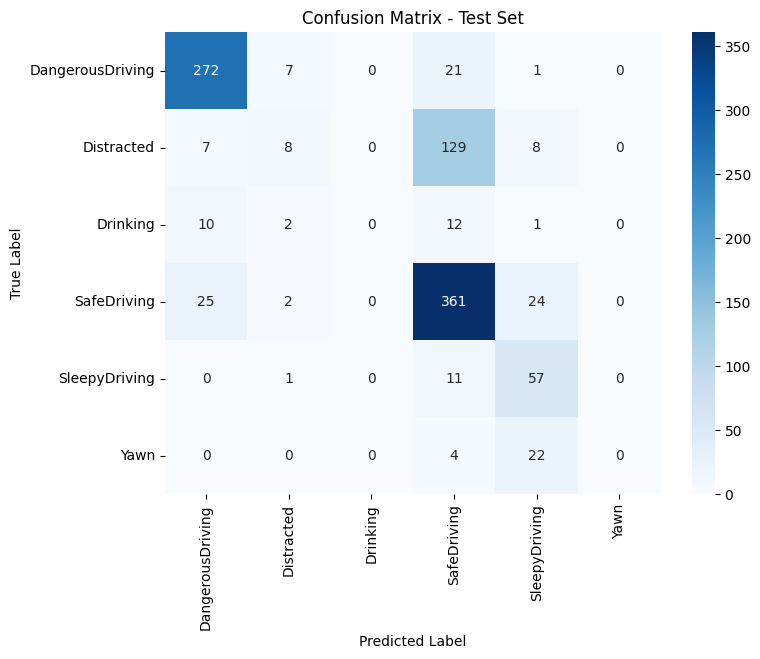

In [ ]:
# For the test set
y_test_true = test_data.classes
y_test_prob = model.predict(test_data)
y_test_pred = np.argmax(y_test_prob, axis=1)

cm_test = confusion_matrix(y_test_true, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
print("Classification Report - Validation Set:")
print(classification_report(y_val_true, y_val_pred, target_names=classes))

Classification Report - Validation Set:
                  precision    recall  f1-score   support

DangerousDriving       0.89      0.92      0.90       609
      Distracted       0.50      0.09      0.15       252
        Drinking       0.00      0.00      0.00        56
     SafeDriving       0.71      0.92      0.80       799
   SleepyDriving       0.46      0.79      0.58       125
            Yawn       0.00      0.00      0.00        81

        accuracy                           0.74      1922
       macro avg       0.43      0.45      0.41      1922
    weighted avg       0.67      0.74      0.68      1922



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
print("Classification Report - Test Set:")
print(classification_report(y_test_true, y_test_pred, target_names=classes))

Classification Report - Test Set:
                  precision    recall  f1-score   support

DangerousDriving       0.87      0.90      0.88       301
      Distracted       0.40      0.05      0.09       152
        Drinking       0.00      0.00      0.00        25
     SafeDriving       0.67      0.88      0.76       412
   SleepyDriving       0.50      0.83      0.63        69
            Yawn       0.00      0.00      0.00        26

        accuracy                           0.71       985
       macro avg       0.41      0.44      0.39       985
    weighted avg       0.64      0.71      0.65       985



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


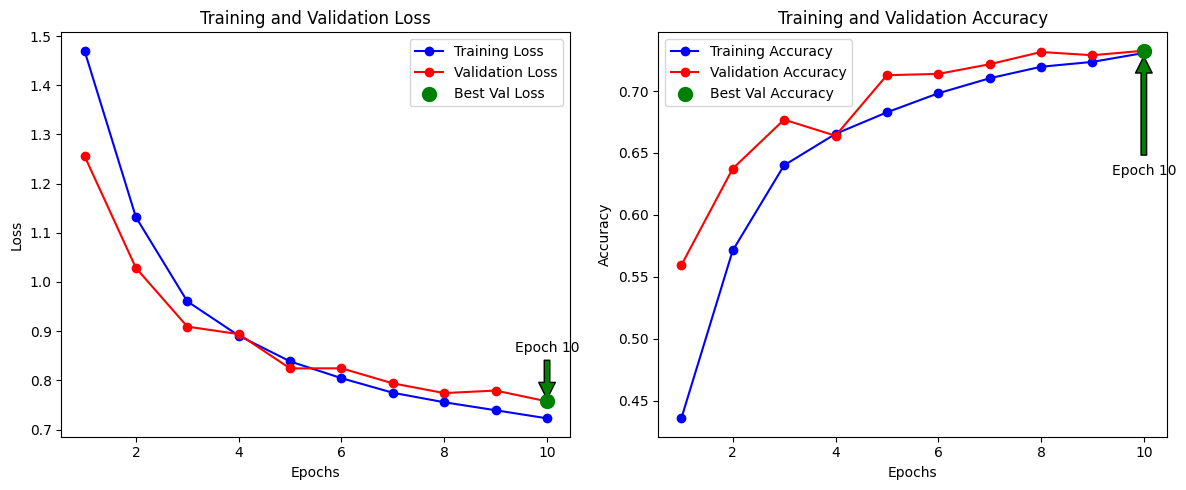

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract metrics from the training history.
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy', history.history.get('acc'))  # 'accuracy' or 'acc'
val_accuracy = history.history.get('val_accuracy', history.history.get('val_acc'))

epochs = range(1, len(loss) + 1)

# Determine best epoch for validation loss (minimum loss) and validation accuracy (maximum accuracy)
best_epoch_val_loss_index = np.argmin(val_loss)
best_epoch_val_loss = best_epoch_val_loss_index + 1  # epochs start at 1
best_val_loss_value = val_loss[best_epoch_val_loss_index]

best_epoch_val_acc_index = np.argmax(val_accuracy)
best_epoch_val_acc = best_epoch_val_acc_index + 1  # epochs start at 1
best_val_acc_value = val_accuracy[best_epoch_val_acc_index]

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
# Mark best validation loss
plt.scatter(best_epoch_val_loss, best_val_loss_value, color='green', s=100, zorder=5, label='Best Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# Annotate the best validation loss point
plt.annotate(f'Epoch {best_epoch_val_loss}',
             xy=(best_epoch_val_loss, best_val_loss_value),
             xytext=(best_epoch_val_loss, best_val_loss_value + 0.1),
             arrowprops=dict(facecolor='green', shrink=0.05),
             horizontalalignment='center')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
# Mark best validation accuracy
plt.scatter(best_epoch_val_acc, best_val_acc_value, color='green', s=100, zorder=5, label='Best Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# Annotate the best validation accuracy point
plt.annotate(f'Epoch {best_epoch_val_acc}',
             xy=(best_epoch_val_acc, best_val_acc_value),
             xytext=(best_epoch_val_acc, best_val_acc_value - 0.1),
             arrowprops=dict(facecolor='green', shrink=0.05),
             horizontalalignment='center')

plt.tight_layout()
plt.show()


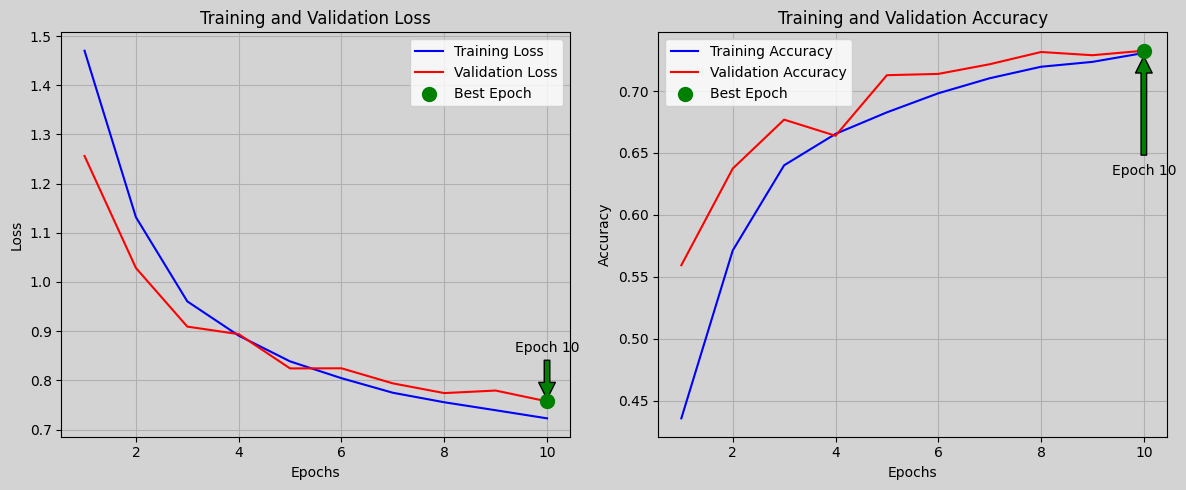

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Extract metrics from the training history.
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history.get('accuracy', history.history.get('acc'))
val_accuracy = history.history.get('val_accuracy', history.history.get('val_acc'))

epochs = range(1, len(loss) + 1)

# Determine best epoch for validation loss (lowest loss) and validation accuracy (highest accuracy)
best_epoch_val_loss_index = np.argmin(val_loss)
best_epoch_val_loss = best_epoch_val_loss_index + 1  # Convert index to epoch number
best_val_loss_value = val_loss[best_epoch_val_loss_index]

best_epoch_val_acc_index = np.argmax(val_accuracy)
best_epoch_val_acc = best_epoch_val_acc_index + 1  # Convert index to epoch number
best_val_acc_value = val_accuracy[best_epoch_val_acc_index]

# Create figure with a gray background.
plt.figure(figsize=(12, 5), facecolor='lightgray')

# Plot Loss
ax1 = plt.subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='Training Loss')      # Blue line without markers
ax1.plot(epochs, val_loss, 'r-', label='Validation Loss')  # Red line without markers
# Mark best validation loss point
ax1.scatter(best_epoch_val_loss, best_val_loss_value, color='green', s=100, zorder=5, label='Best Epoch')
ax1.set_title('Training and Validation Loss', color='black')
ax1.set_xlabel('Epochs', color='black')
ax1.set_ylabel('Loss', color='black')
ax1.legend()
ax1.annotate(f'Epoch {best_epoch_val_loss}',
             xy=(best_epoch_val_loss, best_val_loss_value),
             xytext=(best_epoch_val_loss, best_val_loss_value + 0.1),
             arrowprops=dict(facecolor='green', shrink=0.05),
             horizontalalignment='center', color='black')
ax1.grid(True)                  # Add grid lines
ax1.set_facecolor('lightgray')       # Set axes background to gray

# Plot Accuracy
ax2 = plt.subplot(1, 2, 2)
ax2.plot(epochs, accuracy, 'b-', label='Training Accuracy')      # Blue line without markers
ax2.plot(epochs, val_accuracy, 'r-', label='Validation Accuracy')  # Red line without markers
# Mark best validation accuracy point
ax2.scatter(best_epoch_val_acc, best_val_acc_value, color='green', s=100, zorder=5, label='Best Epoch')
ax2.set_title('Training and Validation Accuracy', color='black')
ax2.set_xlabel('Epochs', color='black')
ax2.set_ylabel('Accuracy', color='black')
ax2.legend()
ax2.annotate(f'Epoch {best_epoch_val_acc}',
             xy=(best_epoch_val_acc, best_val_acc_value),
             xytext=(best_epoch_val_acc, best_val_acc_value - 0.1),
             arrowprops=dict(facecolor='green', shrink=0.05),
             horizontalalignment='center', color='black')
ax2.grid(True)                  # Add grid lines
ax2.set_facecolor('lightgray')       # Set axes background to gray

plt.tight_layout()
plt.show()


# 5. Model evaluation